<a href="https://colab.research.google.com/github/bsantos/multi_index_db/blob/test/Advance_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25, wandbact=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1, 2, 0)

  if wandbact == 1:
    wandb.log({ name: wandb.Image(grid.numpy().clip(0, 1)) })

  plt.imshow(grid.clip(0, 1))
  plt.show()

### parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cpu'#'cuda'

cur_step = 0
crit_cycles = 5
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35

wandbact = 1 # track stats


In [ ]:
!pip install wandb -qqq
import wandb

wandb.login(key='b01b795076ac12c336d2f1429e741ebbc5c60c3f')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
experiment_name = wandb.util.generate_id()
myrun = wandb.init(
    project='wgan',
    group=experiment_name,
    config={
        "optimizer": "adam",
        "model": "wgan gp",
        "epoch": "1000",
        "batch_size": 128
    }
)

config = wandb.config

wandb: Currently logged in as: nayart3 (cppdev). Use `wandb login --relogin` to force relogin


In [ ]:
print(experiment_name)

ytn4s5ec


In [24]:
# generator model

class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()

    self.z_dim = z_dim
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 ch: 200 => 512
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 32, d_dim * 16, 4, 2, 1), ## 8x8 ch: 512 => 256
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 16, d_dim * 8, 4, 2, 1), ## 16x16 ch: 256 => 128
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 8, d_dim * 4, 4, 2, 1), ## 32x32 ch: 128 => 64
        nn.BatchNorm2d(d_dim * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 4, d_dim * 2, 4, 2, 1), ## 64x64 ch: 64 => 32
        nn.BatchNorm2d(d_dim * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim * 2, 3, 4, 2, 1), ## 128x128 ch: 32 => 3
        nn.Tanh(), ### normalize output from -1 to 1
    )

  def forward(self, noise):
    x = noise.view(len(noise), self.z_dim, 1, 1) # 128x200x1x1
    return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
  return torch.randn(num, z_dim, device=device)

In [ ]:
# critic model

class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        nn.Conv2d(3, d_dim, 4, 2, 1), ## 64x64 ch: 3 => 16
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1), ## 32x32 ch: 16 => 32
        nn.InstanceNorm2d(d_dim * 2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 2, d_dim * 4, 4, 2, 1), ## 16x16 ch: 32 => 64
        nn.InstanceNorm2d(d_dim * 4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 4, d_dim * 8, 4, 2, 1), ## 8x8 ch: 64 => 128
        nn.InstanceNorm2d(d_dim * 8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 8, d_dim * 16, 4, 2, 1), ## 4x4 ch: 128 => 256
        nn.InstanceNorm2d(d_dim * 16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim * 16, 1, 4, 1, 0), ## 1x1 ch: 256 => 1
    )

  def forward(self, image):
    # image: 128x3x128x128
    crit_pred = self.crit(image) ## 128x1x1x1
    return crit_pred.view(len(crit_pred), -1) ## 128x1

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d):
    torch.nn.init.normal_(m_weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m_weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m_weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

In [21]:
# load dataset
import zipfile

path = 'data/celeb'
download_path = f'{path}/img_align_celeba.zip'

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)


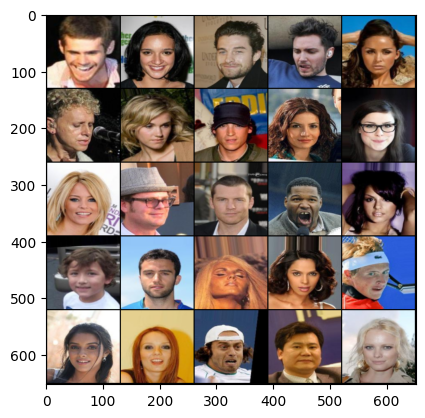

In [43]:
# data

class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    #super(self, Dataset).__init__()

    self.size = [size, size]
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data)

    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB')
    data = np.asarray(transforms.Resize(self.size)(data)) # 128x128x3
    data = np.transpose(data, (2, 0, 1)).astype(np.float32, copy=False) # 3x128x128
    data = torch.from_numpy(data).div(255) # from 0 to 255
    return data, self.labels[idx]

## dataset
ds = Dataset('./data/celeb/img_align_celeba', size=128, lim=10000)

## dataloader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

## models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

# wandb (optional)
if wandbact == 1:
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x,y = next(iter(dataloader))
show(x)

In [45]:
## gradient penalty calc
def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1 - alpha)
  mix_scores = crit(mix_images)

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0]

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  gp = ((gradient_norm - 1)**2).mean()

  return gp

In [42]:
## save and load checkpoints
root_path = './data'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f"{root_path}/G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}/C-{name}.pkl")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}/G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}/C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
## training loop

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs = len(real)
    real = real.to(device)

    ### critic
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs, z_dim, device=device)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
      mean_crit_loss += crit_loss.item() / crit_cycles
      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses += [mean_crit_loss]

    ## generator
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim, device=device)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

    ### stats
    if (wandbact == 1):
      wandb.log({ 'Epoch': epoch, 'Step': cur_step, 'Critic loss': mean_crit_loss, 'Gen loss': gen_loss })

    if cur_step % save_step == 0 and cur_step > 0:
      print("saving checkpoint: ", cur_step, save_step)
      save_checkpoint("latest")

    if cur_step % show_step == 0 and cur_step > 0:
      show(fake, wandbact=1, name='fake')
      show(real, wandbact=1, name='real')

      gen_mean = sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}, Step: {cur_step}, Critic loss: {crit_mean}, Gen loss: {gen_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-1000, 1000)
      plt.legend()
      plt.show()

    cur_step += 1

  0%|          | 0/79 [00:00<?, ?it/s]